In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
config = {}
config['patch_size'] = 3
config['number_of_patches_per_zone'] = 1
config['n_iter'] = 1

## Utils

In [3]:
def Patch(Image, i, j):
    """ Returns a m x m patch taken from Image, centered at coordinates i,j """
    m = int((config['patch_size'] - 1) / 2)
    patch = Image[i-m:i+m+1, j-m:j+m+1, :]
    return patch

In [4]:
def pad(image, pad_size):
    """ Zero-pads an image for all its channels """
    new_shape = (image.shape[0] + 2*pad_size, image.shape[1] + 2*pad_size, image.shape[2])
    padded_image = np.zeros(shape=new_shape, dtype=image.dtype)
    
    channels = range(image.shape[2])
    for c in channels:
        padded_image[:,:,c] = np.pad(image[:,:,c], pad_width=pad_size, mode='constant')
    
    return padded_image

In [5]:
def valid(coord, coord_limit, m):
    """ Makes sure the coordinates lie in a valid range (m corrects for the zero-padding) """
    coord = max(coord, m)
    coord = min(coord, coord_limit + m - 1)
    
    return coord

In [6]:
def warp(B, NNF_ab):
    """ Warp exprimes the content of image A but only with pixels sampled from image B """
    Warp = im2[NNF_ab[:,:,0], NNF_ab[:,:,1], :]
    
    return Warp

## Similarity Metric

In [13]:
def EuclideanDistance(P1, P2):
    """ Returns euclidian distance between two patches """
    distance = np.linalg.norm(P1.astype(np.float) - P2.astype(np.float))
    return distance

## PatchMatch

In [14]:
def initializeNNF(h, w):
    """ 
    Randomly initializes NNF_ab
    - NNF_ab[i,j,:] is a 2D vector representing the coordinates x,y 
      so that B[x,y,:] is most similar to A[i,j,:] 
    """
    # Instanciates NNF_ab
    NNF_ab = np.zeros(shape=(h,w,2), dtype=np.int)
    
    # Fill in NNF_ab[:,:,0] contains the coordinate x (row)
    NNF_ab[:,:,0] = np.random.randint(low=0, high=h, size=(h,w))
        
    # Fill in NNF_ab[:,:,1] contains the coordinate y (column)
    NNF_ab[:,:,1] = np.random.randint(low=0, high=w, size=(h,w))
    
    return NNF_ab

In [15]:
def propagate(A, B, h, w, NNF_ab, i, j, shift):
    # Patch half-size
    m = int((config['patch_size'] - 1) / 2)

    # Extract the patch at coordinates i,j in A
    A_patch = Patch(A,i,j)

    # Extract the patch-match in B associated with current position, left neighbor and up neighbor in A
    A_current_patchMatch = Patch(B, NNF_ab[i,j,0], NNF_ab[i,j,1])
    A_leftNeighbor_patchMatch = Patch(B, NNF_ab[valid(i+shift,h,m),j,0], NNF_ab[valid(i+shift,h,m),j,1])
    A_upNeighbor_patchMatch = Patch(B, NNF_ab[i,valid(j+shift,w,m),0], NNF_ab[i,valid(j+shift,w,m),1])

    # Computes the distance between current patch and the three potential matches ()
    current_match = EuclideanDistance(A_patch, A_current_patchMatch)
    left_neighbor_match = EuclideanDistance(A_patch, A_leftNeighbor_patchMatch)
    up_neighbor_match = EuclideanDistance(A_patch, A_upNeighbor_patchMatch)

    # Looks up which match is the best. If best match is current match, nothing is changed
    best_match = np.argmin(np.array([current_match, left_neighbor_match, up_neighbor_match]))

    """
    if best_match == 1:
        # New patch-match in B is the same than for left-neighbor in A
        NNF_ab[i,j,:] = NNF_ab[valid(i+shift,h,m),j,:]

    if best_match == 2:
        # New patch-match in B is the same than for up-neighbor in A
        NNF_ab[i,j,:] = NNF_ab[i,valid(j+shift,w,m),:]
    """
    if best_match == 1:
        # New patch-match in B based on left-neighbor's match
        NNF_ab[i,j,0] = NNF_ab[i+shift,j,0]
        NNF_ab[i,j,1] = valid(NNF_ab[i+shift,j,1]+1, w, m)

    if best_match == 2:
        # New patch-match in B based on up-neighbor's match
        NNF_ab[i,j,0] = valid(NNF_ab[i,j+shift,0]+1, h, m)
        NNF_ab[i,j,1] = NNF_ab[i,j+shift,1]

    return NNF_ab

In [16]:
def randomSearch(A, B, h, w, NNF_ab, i, j):
    # Patch half-size
    m = int((config['patch_size'] - 1) / 2)

    max_step = 5
    while max_step < max(h,w):

        for k in range(config['number_of_patches_per_zone']):
            # The randomly sampled coordinates for the random patch-match
            [x, y] = NNF_ab[i,j,:] + np.random.randint(low=-max_step, high=max_step, size=(2,))

            # Makes sure that those coordinates lie within the limits of our image
            x = valid(x, h, m)
            y = valid(y, w, m)

            # Extract the patch around our current position in A
            A_patch = Patch(A,i,j)

            # Extract current patch-match and random patch-match in B
            A_current_patchMatch = Patch(B, NNF_ab[i,j,0], NNF_ab[i,j,1])
            A_random_patchMatch = Patch(B, x, y)

            # Computes how good both matches are
            current_match = EuclideanDistance(A_patch, A_current_patchMatch)
            random_match = EuclideanDistance(A_patch, A_random_patchMatch)

            # Looks up which match is the best. If best match is current match, nothing is changed
            best_match = np.argmin(np.array([current_match, random_match]))

            if best_match == 1:
                NNF_ab[i,j,:] = np.array([x,y])

            max_step *= 3
                    
    return NNF_ab

In [17]:
def PatchMatch(image1, image2):
    
    # Makes sure the two images have the same size
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same size.")
    
    # Heigth and Width of images
    [h,w] = image1.shape[0:2]
     
    # Patch half-size
    m = int((config['patch_size'] - 1) / 2)
    
    # Randomly initializes NNF_ab
    NNF_ab = initializeNNF(h,w)
    
    # Zero-Pad images
    A = pad(image1, pad_size=m)
    B = pad(image2, pad_size=m)
    
    # Zero-Pad NNF_ab so its coordinate system as well as the values it contains remains consistent with images A and B
    NNF_ab += m
    NNF_ab = pad(NNF_ab, pad_size=m)
    
    # Defines valid ranges (exclude the padded indexes)
    i_range = np.arange(h) + m
    j_range = np.arange(w) + m
    
    # Executes the PatchMatch algorithm n_iter times
    for step in range(config['n_iter']):
        print("Iteration {0} -----".format(step+1))
        if step%2 == 0:
            shift = 1
        else:
            shift = -1
        
        # For every valid pixel in the image
        for i in i_range:
            if (i+1)%100 == 0 : print("Row : {0}".format(i+1))
            for j in j_range:
                NNF_ab = propagate(A, B, h, w, NNF_ab, i, j, shift)
                NNF_ab = randomSearch(A, B, h, w, NNF_ab, i, j)
    
    NNF_final = NNF_ab[m:-m, m:-m, :]
    NNF_final -= m
    
    print("Done!")
    
    return NNF_final

## Warping

Iteration 1 -----
Row : 100
Row : 200
Row : 300
Row : 400
Iteration 2 -----
Row : 100
Row : 200
Row : 300
Row : 400
Done!
 

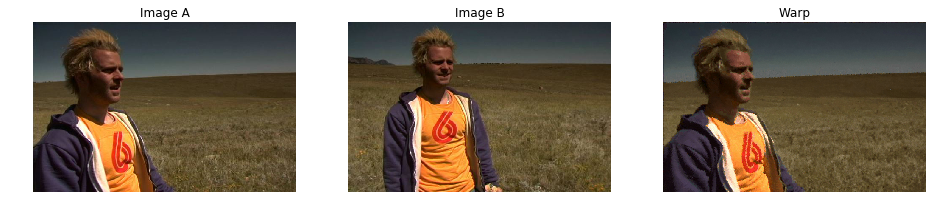

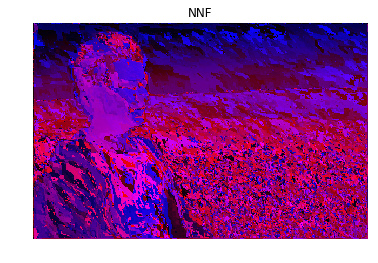

In [18]:
# Load the images
im1 = plt.imread(os.path.join("Images", "Image1.jpg"))
im2 = plt.imread(os.path.join("Images", "Image2.jpg"))

# Runs the PatchMatch algorithm
%prun NNF = PatchMatch(im1, im2)


# Displays the original images and resulting Warp
plt.figure(figsize=(16, 12))
plt.subplot(131)
plt.imshow(im1)
plt.title("Image A")
plt.axis("off")

plt.subplot(132)
plt.imshow(im2)
plt.title("Image B")
plt.axis("off")

plt.subplot(133)
plt.imshow(warp(im2, NNF))
plt.title("Warp")
plt.axis("off")
plt.show()


# Displays the NNF (mapping function)
zer = np.zeros(shape=(NNF.shape[0], NNF.shape[1], 1), dtype=NNF.dtype)
colorNNF = np.concatenate((np.expand_dims(NNF[:,:,0], 2), zer, np.expand_dims(NNF[:,:,1], 2)), axis=2)

plt.imshow(colorNNF.astype(np.uint8))
plt.title("NNF")
plt.axis("off")
plt.show()